# Data Scientist Professional Practical Exam Submission

**Use this template to write up your summary for submission. Code in Python or R needs to be included.**


## 📝 Task List

Your written report should include both code, output and written text summaries of the following:
- Data Validation:   
  - Describe validation and cleaning steps for every column in the data 
- Exploratory Analysis:  
  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings
- Model Development
  - Include your reasons for selecting the models you use as well as a statement of the problem type
  - Code to fit the baseline and comparison models
- Model Evaluation
  - Describe the performance of the two models based on an appropriate metric
- Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach
- Final summary including recommendations that the business should undertake

*Start writing report here..*

## Initial Setup

In [99]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.tree import DecisionTreeClassifier

# General settings
plt.rcParams['figure.figsize'] = (4, 3)
sns.set(context='paper')

## Data Ingestion

In [100]:
df = pd.read_csv('recipe_site_traffic_2212.csv', index_col='recipe')

## Data Validation and Wrangling

In [101]:
# Round 'Nutritional Facts' columns so that they 
cols = ['calories', 'carbohydrate', 'sugar', 'protein']
df[cols] = df[cols].round()

# Wrangle 'servings' column. Extract only integers.
df['servings'] = df['servings'].str[:1].astype(int)

# Recode 'high_traffic' column where True = 'high_traffic'
df['high_traffic'] = np.where(df['high_traffic'].isnull(), False, True)

# Wrangle 'category' column
df['category'] = df['category'].str.replace(' Breast', '').astype('category')

# Add column to indicate if all the nutritional facts are displayed on the website
count_nan_per_row = df[cols].isna().sum(axis=1)
df['nutritional_facts_label'] = np.where(count_nan_per_row == len(cols), False, True)

# Sort columns
num_features = ['calories', 'carbohydrate', 'sugar', 'protein', 'servings', 'nutritional_facts_label']
cat_features = ['category']
target = ['high_traffic']
df = df[num_features + cat_features + target]

## Exploratory Analysis

  - Include two different graphics showing single variables only to demonstrate the characteristics of data  
  - Include at least one graphic showing two or more variables to represent the relationship between features
  - Describe your findings

In [102]:
df.head()

,calories,carbohydrate,sugar,protein,servings,nutritional_facts_label,category,high_traffic
recipe,,,,,,,,
1,NaN,NaN,NaN,NaN,6,False,Pork,True
2,35.0,39.0,1.0,1.0,4,True,Potato,True
3,914.0,43.0,3.0,3.0,1,True,Breakfast,False
4,97.0,31.0,39.0,0.0,4,True,Beverages,True
5,27.0,2.0,1.0,1.0,4,True,Beverages,False


In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 947 entries, 1 to 947
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   calories                 895 non-null    float64 
 1   carbohydrate             895 non-null    float64 
 2   sugar                    895 non-null    float64 
 3   protein                  895 non-null    float64 
 4   servings                 947 non-null    int32   
 5   nutritional_facts_label  947 non-null    bool    
 6   category                 947 non-null    category
 7   high_traffic             947 non-null    bool    
dtypes: bool(2), category(1), float64(4), int32(1)
memory usage: 43.8 KB


In [104]:
df.describe().round(2)

,calories,carbohydrate,sugar,protein,servings
count,895.00,895.00,895.00,895.00,947.00
mean,435.96,35.07,9.06,24.15,3.48
std,453.00,43.95,14.68,36.38,1.73
min,0.00,0.00,0.00,0.00,1.00
25%,110.50,8.00,2.00,3.00,2.00
50%,289.00,21.00,5.00,11.00,4.00
75%,598.00,45.00,10.00,30.00,4.00
max,3633.00,530.00,149.00,363.00,6.00


In [105]:
df.describe(include=['category', bool])

,nutritional_facts_label,category,high_traffic
count,947,947,947
unique,2,10,2
top,True,Chicken,True
freq,895,172,574


### Target Variable

#### High_traffic

There is class balance in the target variable. The majority class is True, which represents recipes which resulted in high traffic.

In [106]:
target = 'high_traffic'

n = df[target].value_counts().rename('n')
p = df[target].value_counts(normalize=True).rename('p').round(2)

table = pd.concat([n, p], axis=1).rename_axis(target).reset_index()
table

,high_traffic,n,p
0,True,574,0.61
1,False,373,0.39


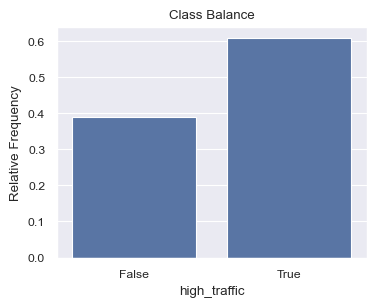

In [107]:
sns.barplot(data=table, x=target, y='p')
plt.ylabel('Relative Frequency')
plt.title('Class Balance');

## Feature Variables

### Calories

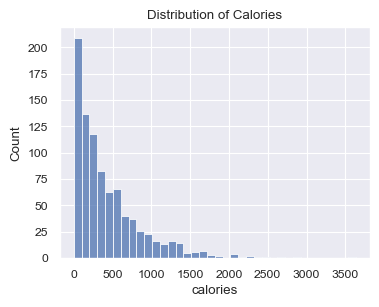

In [108]:
feature = 'calories'

sns.histplot(df[feature])
plt.title('Distribution of Calories');

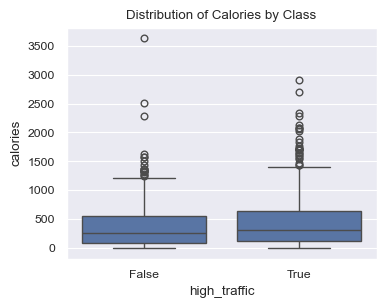

In [109]:
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Calories by Class');

The number of calories does not seem to have significant impact on high_traffic. 

In [110]:
x = df.groupby(target)[feature].mean().round(2).reset_index()
x

,high_traffic,calories
0,False,394.91
1,True,463.58


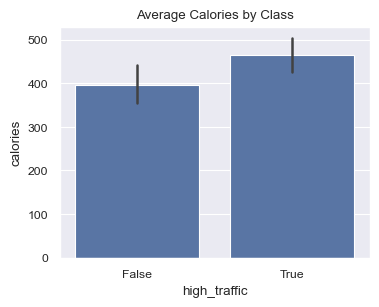

In [111]:
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Calories by Class');

### Carbohydrate

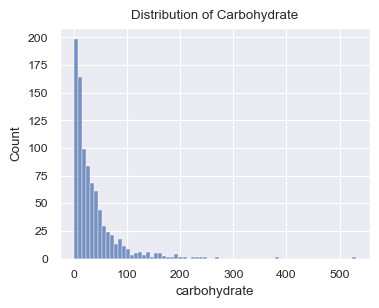

In [112]:
feature = 'carbohydrate'

sns.histplot(df[feature])
plt.title('Distribution of Carbohydrate');

The number of carbohydrates does not seem to have significant impact on high_traffic. 

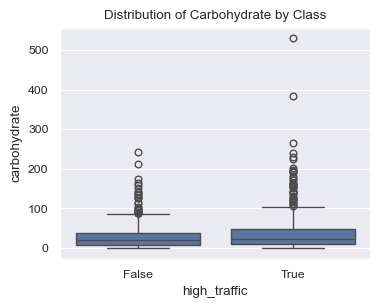

In [113]:
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Carbohydrate by Class');

In [114]:
x = df.groupby(target)[feature].mean().round(2).reset_index()
x

,high_traffic,carbohydrate
0,False,30.73
1,True,37.99


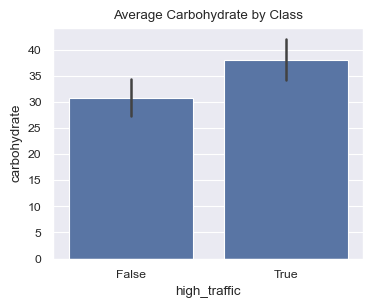

In [115]:
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Carbohydrate by Class');

### Sugar

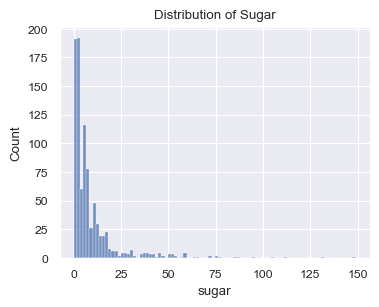

In [116]:
feature = 'sugar'

sns.histplot(df[feature])
plt.title('Distribution of Sugar');

The amount of sugar does not seem to have significant impact on high_traffic. 

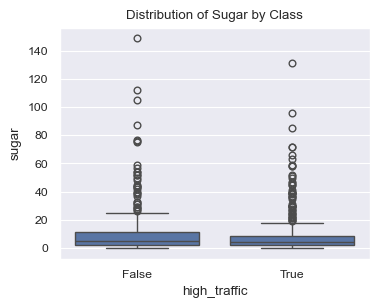

In [117]:
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Sugar by Class');

In [118]:
x = df.groupby(target)[feature].mean().round(2).reset_index()
x

,high_traffic,sugar
0,False,10.41
1,True,8.15


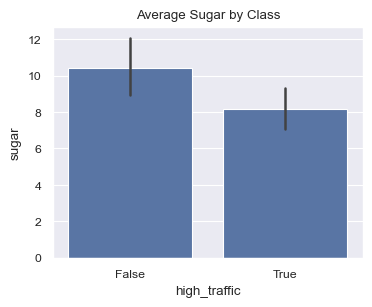

In [119]:
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Sugar by Class');

### Protein

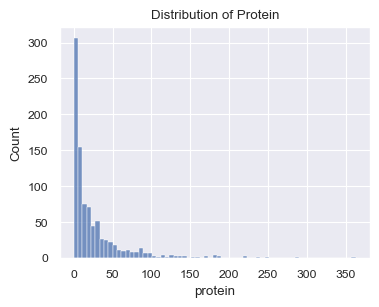

In [120]:
feature = 'protein'

sns.histplot(df[feature])
plt.title('Distribution of Protein');

The number of proteins does not seem to have significant impact on high_traffic. 

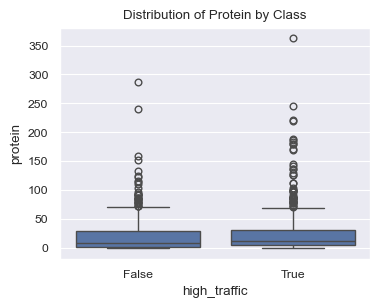

In [121]:
sns.boxplot(df, x=target, y=feature)
plt.title('Distribution of Protein by Class');

In [122]:
x = df.groupby(target)[feature].mean().round(2).reset_index()
x

,high_traffic,protein
0,False,22.17
1,True,25.47


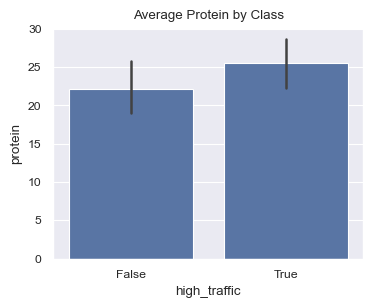

In [123]:
sns.barplot(data=df, x=target, y=feature)
plt.title('Average Protein by Class');

### Category

The majority class is Chicken with 18%.

In [124]:
feature = 'category'

df[feature].value_counts(normalize=True).round(2)

category
Chicken          0.18
Breakfast        0.11
Beverages        0.10
Lunch/Snacks     0.09
Potato           0.09
Pork             0.09
Dessert          0.09
Vegetable        0.09
Meat             0.08
One Dish Meal    0.07
Name: proportion, dtype: float64

In [125]:
x = df.groupby(feature, observed=False)[target].mean().round(4).sort_values(ascending=False)
x

category
Vegetable        0.9880
Potato           0.9432
Pork             0.9167
Meat             0.7468
One Dish Meal    0.7324
Lunch/Snacks     0.6404
Dessert          0.6386
Chicken          0.4244
Breakfast        0.3113
Beverages        0.0543
Name: high_traffic, dtype: float64

Certain categories of recipes are associated with high traffic recipes. In order of importance, these include: Vegetable, Potato, Pork, Meat, and One Dish Meal.

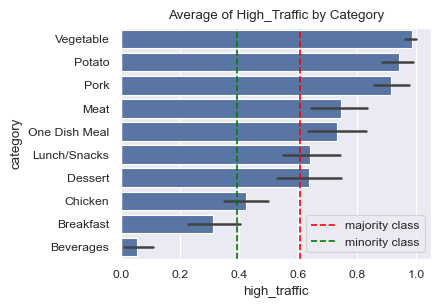

In [126]:
# Obtain majority and minority class proportions
majority_class_prop, minority_class_prop = df['high_traffic'].value_counts(normalize=True)

# Plot category vs high_traffic
sns.barplot(data=df, x='high_traffic', y=feature, orient='h', order=x.index)
plt.axvline(majority_class_prop, linestyle='--', color='red', label='majority class')
plt.axvline(minority_class_prop, linestyle='--', color='green', label='minority class')
plt.title('Average of High_Traffic by Category')
plt.legend(loc='lower right');

### Servings

In [127]:
feature = 'servings'

df[feature].value_counts(normalize=True).round(2)

servings
4    0.41
6    0.21
2    0.19
1    0.18
Name: proportion, dtype: float64

The number of servings does not seem to be associated with high traffic recipes.

In [128]:
x = df.groupby(feature, observed=False)[target].mean().round(4).sort_values(ascending=False)
x

servings
6    0.6515
4    0.6061
1    0.5886
2    0.5738
Name: high_traffic, dtype: float64

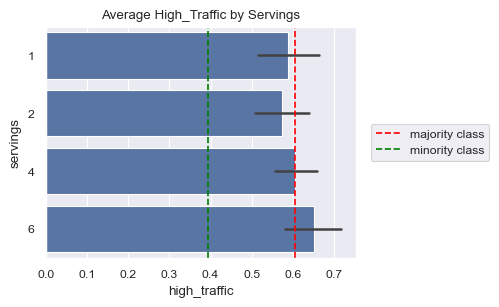

In [129]:
sns.barplot(data=df, x=target, y=feature, orient='h')
plt.title('Average High_Traffic by Servings')
plt.axvline(majority_class_prop, linestyle='--', color='red', label='majority class')
plt.axvline(minority_class_prop, linestyle='--', color='green', label='minority class')
plt.legend(loc='center right', bbox_to_anchor=(1.45, 0.5));

### Nutritional Facts Label

In [130]:
feature = 'nutritional_facts_label'

df[feature].value_counts(normalize=True)

nutritional_facts_label
True     0.94509
False    0.05491
Name: proportion, dtype: float64

It seems that the lack of a Nutritional Fact Label is associated with lower traffic recipes.

In [135]:
df.groupby(feature, observed=False)[target].mean().round(4).sort_values(ascending=False)

nutritional_facts_label
False    0.7500
True     0.5978
Name: high_traffic, dtype: float64

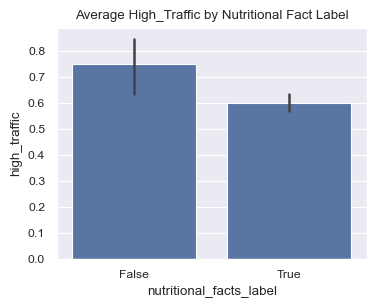

In [134]:
sns.barplot(data=df, x=feature, y=target)
plt.title('Average High_Traffic by Nutritional Fact Label');

## Model Development
- Include your reasons for selecting the models you use as well as a statement of the problem type
- Code to fit the baseline and comparison models
- Predict which recipes will lead to high traffic?
- Correctly predict high traffic recipes 80% of the time?

Classification: Logistic Regression or Tree-based model
Key metric: Precision (Minimize false positives)

### Split

In [137]:
target = 'high_traffic'

X = df.drop(columns=target)
y = df[target]

print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (947, 7)
y shape: (947,)


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (757, 7)
y_train shape: (757,)
X_test shape: (190, 7)
y_test shape: (190,)


### Baseline

In [139]:
majority_class = y_train.value_counts(normalize=True).idxmax()
accuracy_baseline = y_train.value_counts(normalize=True).max()

majority_classifier = DummyClassifier(strategy='most_frequent')
majority_classifier.fit(X_train, y_train)
y_pred_majority = majority_classifier.predict(X_test)
precision_baseline = precision_score(y_test, y_pred_majority)

print('Majority_class:', majority_class)
print('Baseline Accuracy:', round(accuracy_baseline, 4))
print('Baseline precision:', round(precision_baseline, 4))

Majority_class: True
Baseline Accuracy: 0.5984
Baseline precision: 0.6368


### Iterate

#### Logistic Regression

In [140]:
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OneHotEncoder(), cat_features)]
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'preprocessor__num__strategy': ['mean', 'median']
}

model_logreg = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         SimpleImputer(),
                                                                         ['calories',
                                                                          'carbohydrate',
                                                                          'sugar',
                                                                          'protein',
                                                                          'servings',
                                                                          'nutritional_facts_label']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['category'])])),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'preprocessor__num__strategy': ['mean', 'median']},
             verbose=1)

#### Decision Tree Classifier

In [ ]:
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OrdinalEncoder(), cat_features)]
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

param_grid = {
    'preprocessor__num__strategy': ['mean', 'median'],
    'classifier__max_depth': range(1, 51, 5),
}

model_dt = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_dt.fit(X_train, y_train)

#### Random Forest

In [ ]:
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OrdinalEncoder(), cat_features)]
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'preprocessor__num__strategy': ['mean', 'median'],
    'classifier__max_depth': range(10, 51, 10),
    'classifier__n_estimators': range(20, 100, 10)
}

model_rf = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_rf.fit(X_train, y_train)

#### Gradient Boosting

In [ ]:
preprocessor = ColumnTransformer(
    [('num', SimpleImputer(), num_features),
     ('cat', OrdinalEncoder(), cat_features)]
)

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

param_grid = {
    'preprocessor__num__strategy': ['mean', 'median'],
    'classifier__max_depth': range(3, 10, 2),
    'classifier__n_estimators': range(20, 100, 10)
}

model_gb = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1)
model_gb.fit(X_train, y_train)

## Model Evaluation
  - Describe the performance of the two models based on an appropriate metric

In [ ]:
models = [model_logreg, model_dt, model_rf, model_gb]

for model in models:

    # Obtain model name
    model_name = type(model.best_estimator_['classifier']).__name__

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Accuracy scores
    accuracy_train = model.score(X_train, y_train)
    accuracy_test = model.score(X_test, y_test)

    # Precision scores
    precision_train = precision_score(y_train, y_train_pred)
    precision_test = precision_score(y_test, y_test_pred)


    print(f'Model: {model_name}', '\n')
    print(confusion_matrix(y_test, y_test_pred), '\n')
    print('Training Accuracy:', '\t', round(accuracy_train, 4))
    print('Training Precision:', '\t', round(precision_train, 4), '\n')
    print('Test Accuracy:', '\t\t', round(accuracy_test, 4))
    print('Test Precision:', '\t', round(precision_test, 4), '\n\n')  

### Communication

In [ ]:
# Get features names from training data
features = model_gb.best_estimator_['preprocessor'].get_feature_names_out()
features = [x[5:] for x in features]

# Extract importances from model
importances = model_gb.best_estimator_['classifier'].feature_importances_

# Create a series with features and importances
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

# Plot 10 most important features
sns.barplot(feat_imp.head(10), orient='h')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.title('Feature Importance');

## Business Metrics
  - Define a way to compare your model performance to the business
  - Describe how your models perform using this approach

## Final Summary
- Final summary including recommendations that the business should undertake

## ✅ When you have finished...
-  Publish your Workspace using the option on the left
-  Check the published version of your report:
	-  Can you see everything you want us to grade?
    -  Are all the graphics visible?
-  Review the grading rubric. Have you included everything that will be graded?
-  Head back to the [Certification Dashboard](https://app.datacamp.com/certification) to submit your practical exam report and record your presentation